In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [31]:
df = pd.read_csv("meteo_data.csv")
df.index = pd.to_datetime(df.DATE)
del df['DATE']

required_cols = ['SOLAR_RADIATION']
df = df[required_cols]
df

,SOLAR_RADIATION
DATE,
2022-10-26 22:00:00,0.0
2022-10-26 23:00:00,0.0
2022-10-27 00:00:00,0.0
2022-10-27 01:00:00,0.0
2022-10-27 02:00:00,0.0
...,...
2024-05-22 17:00:00,447.0
2024-05-22 18:00:00,266.0
2024-05-22 19:00:00,99.0


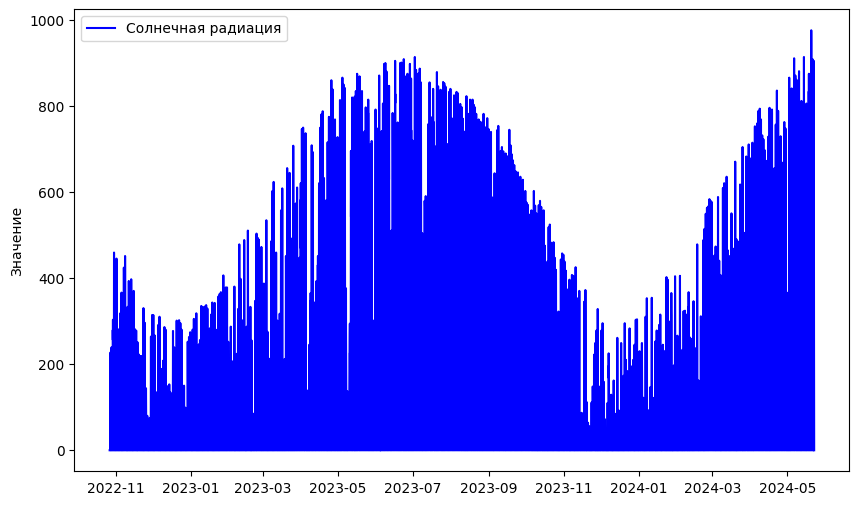

In [32]:
temp = df['SOLAR_RADIATION']

plt.figure(figsize=(10, 6))
plt.plot(df['SOLAR_RADIATION'], label='Солнечная радиация', color='blue')

# Настройка графика
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()

In [59]:
# предсказание, основанное не предыдущем суточном дне
def df_to_X_y(df, window_size=24):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [60]:
WINDOW_SIZE = 24
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
print(X1.shape, y1.shape)

(13739, 24, 1) (13739,)


In [61]:
X_train1, y_train1 = X1[:10500], y1[:10500]
X_val1, y_val1 = X1[10500:11800], y1[10500:11800]
X_test1, y_test1 = X1[11800:], y1[11800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((10500, 24, 1), (10500,), (1300, 24, 1), (1300,), (1939, 24, 1), (1939,))

In [136]:
from keras.layers import LSTM, Dropout, BatchNormalization

model = Sequential()
model.add(InputLayer((WINDOW_SIZE, 1)))

# Первый сверточный слой с большим количеством нейронов
model.add(Conv1D(32000, kernel_size=3, activation='relu'))

# Второй сверточный слой с уменьшением количества нейронов
model.add(Conv1D(16000, kernel_size=3, activation='relu'))

# Третий сверточный слой с уменьшением количества нейронов
model.add(Conv1D(8000, kernel_size=3, activation='relu'))

# Уменьшение количества нейронов в следующих слоях
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(LSTM(4000, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(2000))
model.add(Dropout(0.5))

# Полносвязные слои с уменьшением количества нейронов
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))

# Выходной слой
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)                   │ (None, 22, 32000)           │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 20, 16000)           │   1,536,016,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 18, 8000)            │     384,008,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 9, 8000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 9, 8000)             │          32,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 9, 4000)             │     192,016,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 9, 4000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 2000)                │      48,008,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1000)                │       2,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 250)                 │         125,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,162,835,001 (8.06 GB)

 Trainable params: 2,162,819,001 (8.06 GB)

 Non-trainable params: 16,000 (62.50 KB)

In [137]:
# Настройки обратного вызова и компиляции модели
cp2 = ModelCheckpoint('model2/model2-solar-radiation.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [138]:
# Обучение модели
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2097.4094 - root_mean_squared_error: 45.7291 - val_loss: 798.4205 - val_root_mean_squared_error: 28.1961
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2146.8784 - root_mean_squared_error: 46.3152 - val_loss: 801.5618 - val_root_mean_squared_error: 28.2367
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2209.9082 - root_mean_squared_error: 46.9890 - val_loss: 797.8066 - val_root_mean_squared_error: 28.1684
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2129.1929 - root_mean_squared_error: 46.1146 - val_loss: 798.8923 - val_root_mean_squared_error: 28.1869
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2145.1304 - root_mean_squared_error: 46.2886 - val_loss: 811.0640 - val_root_mean_squared_error: 28.4034
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2127.7925 - root_mean_squared_error: 46.1062 - val_loss: 803.7461 - val_root_mean_squared_error: 28.2636
Epoch 7/5

In [139]:
# Прогнозирование на тестовых данных
y_pred = model2.predict(X_test1)

# Вывод предсказаний
print(y_pred)

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
[[  0.     ]
 [  0.     ]
 [  0.     ]
 ...
 [103.50432]
 [  0.     ]
 [  0.     ]]


In [140]:
# Прогнозирование на будущее
def predict_future(model, last_known_data, last_known_dates, steps=3, window_size=24):
    predictions = []
    future_dates = pd.date_range(start=last_known_dates[-1], periods=steps + 1, freq='h')[1:]
    
    current_data = last_known_data.tolist()
    
    for _ in range(steps):
        input_data = np.array(current_data[-window_size:]).reshape(1, window_size, 1)
        prediction = model.predict(input_data)
        predictions.append(prediction[0, 0])
        current_data.append(prediction[0, 0])
    
    return future_dates, predictions

# Последние известные данные и даты
last_known_data = temp.values[-WINDOW_SIZE:]
last_known_dates = temp.index[-WINDOW_SIZE:]

# Прогнозирование на 3 шага вперед
future_steps = 24
future_dates, predictions = predict_future(model2, last_known_data, last_known_dates, future_steps, WINDOW_SIZE)

# Вывод предсказаний с датами
for date, pred in zip(future_dates, predictions):
    print(f"{date}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2024-05-22 22:00:00: 0.0
2024-05-22 23:00:00: 0.0
2024-05-23 00:00:00: 0.0
2024-05-23 01

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


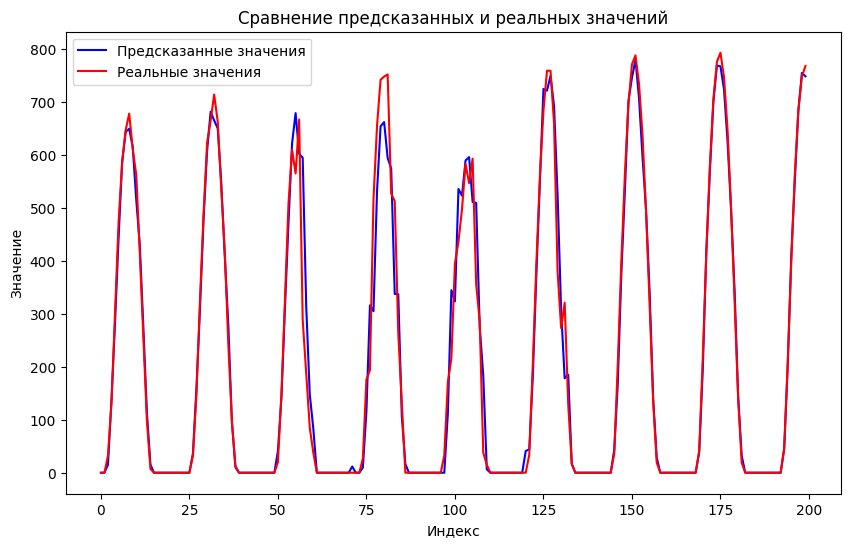

In [141]:
# Предсказание на тестовом наборе данных
y_pred1 = model2.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[700:900], label='Предсказанные значения', color='blue')
plt.plot(y_test1[700:900], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [142]:
# Оценка MAE
mae = mean_absolute_error(y_test1, y_pred1)

# Оценка MSE
mse = mean_squared_error(y_test1, y_pred1)

# Оценка RMSE
rmse = np.sqrt(mse)

# Оценка R^2
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 28.868898987462682
Средняя квадратичная ошибка (MSE): 3648.2656079834896
Корень из среднеквадратичной ошибки (RMSE): 60.400874231947085
Коэффициент детерминации (R^2): 0.9413502753302092
